In [138]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_3 = X[:,[0,2,3]]

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_3)
#m = np.amax(X_scaled)
#X_ball = X_scaled/m

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [140]:
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [141]:
# size of the first layer
l1 = 6
l2 = 27

In [142]:
class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        self.layer2 = nn.Linear(l1, l2)
        self.layer3 = nn.Linear(l2, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [165]:
class Maxbias_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, max_bias, bias):
        return 0.1*np.linalg.norm(np.max(np.array([bias - max_bias, np.zeros_like(bias)]),axis=0))

In [166]:
model     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn_ce   = nn.CrossEntropyLoss() 
loss_fn_maxbias = Maxbias_loss()
model

Model(
  (layer1): Linear(in_features=3, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=27, bias=True)
  (layer3): Linear(in_features=27, out_features=3, bias=True)
)

In [167]:
model_injective = Model(X_train.shape[1],l1)
optimizer_injective = torch.optim.Adam(model_injective.parameters(), lr=0.01)
model

Model(
  (layer1): Linear(in_features=3, out_features=6, bias=True)
  (layer2): Linear(in_features=6, out_features=27, bias=True)
  (layer3): Linear(in_features=27, out_features=3, bias=True)
)

In [168]:
times_to_blowup = 3
X_kd = mcbe.add_kd_samples(X_train,times_to_blowup)

In [181]:
EPOCHS  = 100

weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])

weights_injective = []
weights_norm_injective = []
norms_injective = []
biases_injective = np.zeros([EPOCHS + 1,l1])

w1 = model.layer1.weight
b1 = model.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

w1_injective = model_injective.layer1.weight
b1_injective = model_injective.layer1.bias

weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

weights_injective.append(w1_injective.detach().numpy())
weights_norm_injective.append(w1_norm.detach().numpy())
norms_injective.append(norm.detach().numpy())
biases_injective[0,:] = b1_injective.detach().numpy()


#epoch counter
k = 1

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

loss_list_injective     = np.zeros((EPOCHS,))
ce_loss_list_injective = np.zeros((EPOCHS,))
maxbias_loss_list_injective = np.zeros((EPOCHS,))
accuracy_list_injective = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):

    est_alpha_kd, subframes_kd, est_points_kd = mcbe.be_given_points(polytope=np.array(weights)[-1],points=X_kd, give_subframes=True)

    y_pred = model(X_train)
    loss = loss_fn_ce(y_pred, y_train)
    loss_list[epoch] = loss.item()

    y_pred_injective = model_injective(X_train)
    loss_injective = loss_fn_ce(y_pred_injective, y_train) + loss_fn_maxbias(max_bias = est_alpha_kd , bias = b1.detach().numpy())
    loss_list_injective[epoch] = loss_injective.item()
    ce_loss_list_injective[epoch] = loss_fn_ce(y_pred_injective, y_train).item()
    maxbias_loss_list_injective[epoch] = loss_fn_maxbias(max_bias = est_alpha_kd , bias = b1.detach().numpy()).item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Zero gradients
    optimizer_injective.zero_grad()
    loss_injective.backward()
    optimizer_injective.step()

    w1 = model.layer1.weight
    b1 = model.layer1.bias

    w1_injective = model_injective.layer1.weight
    b1_injective = model_injective.layer1.bias


    model_injective.layer1.bias = torch.nn.Parameter(torch.from_numpy(np.min(np.array([b1.detach().numpy(), est_alpha_kd]),axis=0)).float())
    

    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0

    norm_injective = w1_injective.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm_injective = torch.div(w1_injective,norm_injective)
    w1_norm_injective[w1_norm_injective == np.inf] = 0
    
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()

    weights_injective.append(w1_injective.detach().numpy())
    weights_norm_injective.append(w1_norm_injective.detach().numpy())
    norms_injective.append(norm_injective.detach().numpy())
    biases_injective[k,:] = b1_injective.detach().numpy()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

    with torch.no_grad():
        y_pred_injective = model_injective(X_test)
        correct_injective = (torch.argmax(y_pred_injective, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list_injective[epoch] = correct_injective.mean()
    
    

    
    k = k+1

accuracy_list
accuracy_list_injective

100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


array([0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666

Text(0, 0.5, 'Accuracy')

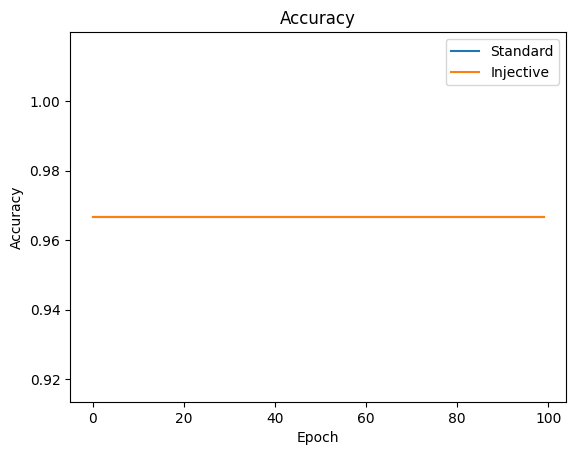

In [182]:
plt.plot(accuracy_list, label='Standard')
plt.plot(accuracy_list_injective, label='Injective')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

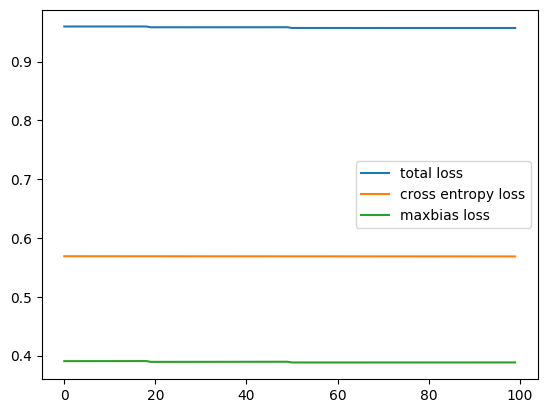

In [183]:

plt.plot(loss_list_injective, label='total loss')
plt.plot(ce_loss_list_injective, label='cross entropy loss')
plt.plot(maxbias_loss_list_injective, label='maxbias loss')
plt.legend()


# mean over multiple trainings

In [149]:
num_iter = 25
accuracy = []
accuracy_injective = []

In [150]:
for i in tqdm.tqdm(range(num_iter)):
    
    model     = Model(X_train.shape[1],l1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn_ce   = nn.CrossEntropyLoss() 
    loss_fn_maxbias = Maxbias_loss()
    model

    model_injective = Model(X_train.shape[1],l1)
    optimizer_injective = torch.optim.Adam(model_injective.parameters(), lr=0.01)
    model

    times_to_blowup = 3
    X_kd = mcbe.add_kd_samples(X_train,times_to_blowup)


    weights = []
    weights_norm = []
    norms = []
    biases = np.zeros([EPOCHS + 1,l1])

    weights_injective = []
    weights_norm_injective = []
    norms_injective = []
    biases_injective = np.zeros([EPOCHS + 1,l1])

    w1 = model.layer1.weight
    b1 = model.layer1.bias
    m1 = w1.shape[0]
    n1 = w1.shape[1]
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0

    w1_injective = model_injective.layer1.weight
    b1_injective = model_injective.layer1.bias

    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[0,:] = b1.detach().numpy()

    weights_injective.append(w1_injective.detach().numpy())
    weights_norm_injective.append(w1_norm.detach().numpy())
    norms_injective.append(norm.detach().numpy())
    biases_injective[0,:] = b1_injective.detach().numpy()


    #epoch counter
    k = 1

    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    loss_list_injective     = np.zeros((EPOCHS,))
    accuracy_list_injective = np.zeros((EPOCHS,))

    for epoch in range(EPOCHS):

        est_alpha_kd, subframes_kd, est_points_kd = mcbe.be_given_points(polytope=np.array(weights)[-1],points=X_kd, give_subframes=True)

        y_pred = model(X_train)
        loss = loss_fn_ce(y_pred, y_train)
        loss_list[epoch] = loss.item()

        y_pred_injective = model_injective(X_train)
        loss_injective = loss_fn_ce(y_pred_injective, y_train) + loss_fn_maxbias(max_bias = est_alpha_kd , bias = b1.detach().numpy())
        loss_list_injective[epoch] = loss_injective.item()
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Zero gradients
        optimizer_injective.zero_grad()
        loss_injective.backward()
        optimizer_injective.step()

        w1 = model.layer1.weight
        b1 = model.layer1.bias

        w1_injective = model_injective.layer1.weight
        b1_injective = model_injective.layer1.bias


        model_injective.layer1.bias = torch.nn.Parameter(torch.from_numpy(np.min(np.array([b1.detach().numpy(), est_alpha_kd]),axis=0)).float())
        

        norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
        w1_norm = torch.div(w1,norm)
        w1_norm[w1_norm == np.inf] = 0

        norm_injective = w1_injective.pow(2).sum(keepdim=True,dim=1).sqrt()
        w1_norm_injective = torch.div(w1_injective,norm_injective)
        w1_norm_injective[w1_norm_injective == np.inf] = 0
        
        
        weights.append(w1.detach().numpy())
        weights_norm.append(w1_norm.detach().numpy())
        norms.append(norm.detach().numpy())
        biases[k,:] = b1.detach().numpy()

        weights_injective.append(w1_injective.detach().numpy())
        weights_norm_injective.append(w1_norm_injective.detach().numpy())
        norms_injective.append(norm_injective.detach().numpy())
        biases_injective[k,:] = b1_injective.detach().numpy()
        
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()

        with torch.no_grad():
            y_pred_injective = model_injective(X_test)
            correct_injective = (torch.argmax(y_pred_injective, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list_injective[epoch] = correct_injective.mean()
        
        

        
        k = k+1

    accuracy.append(accuracy_list)
    accuracy_injective.append(accuracy_list_injective)

100%|██████████| 25/25 [02:38<00:00,  6.33s/it]


In [151]:
accuracy = np.array(accuracy)
accuracy_injective = np.array(accuracy_injective)

In [152]:
mean_accuracy = np.mean(accuracy,axis=0)
std_accuracy = np.std(accuracy,axis=0)
mean_accuracy_injective = np.mean(accuracy_injective,axis=0)
std_accuracy_injective = np.std(accuracy_injective,axis=0)

Text(0, 0.5, 'Accuracy')

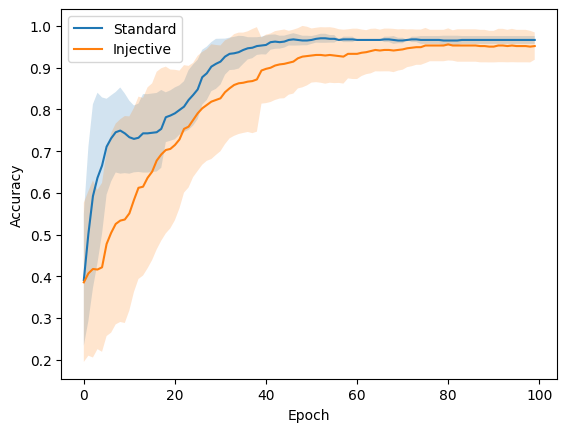

In [153]:
plt.plot(mean_accuracy, label='Standard')
plt.fill_between(range(EPOCHS), mean_accuracy-std_accuracy, mean_accuracy+std_accuracy, alpha=0.2)
plt.plot(mean_accuracy_injective, label='Injective')
plt.fill_between(range(EPOCHS), mean_accuracy_injective-std_accuracy_injective, mean_accuracy_injective+std_accuracy_injective, alpha=0.2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [184]:
#save the data
np.save('mean_accuracy.npy', mean_accuracy)
np.save('std_accuracy.npy', std_accuracy)
np.save('mean_accuracy_injective_in_loss.npy', mean_accuracy_injective)
np.save('std_accuracy_injective_in_loss.npy', std_accuracy_injective)